In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score


In [2]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")


In [3]:
customer_spending = transactions.groupby("CustomerID").agg(
    TotalSpend=('TotalValue', 'sum'),
    TransactionCount=('TransactionID', 'count'),
    AvgTransactionValue=('TotalValue', 'mean')
).reset_index()

customer_data = customers.merge(customer_spending, on="CustomerID", how="left").fillna(0)
customer_data = pd.get_dummies(customer_data, columns=["Region"], drop_first=True)


numeric_cols = customer_data.select_dtypes(include=[np.number]).columns
customer_features = StandardScaler().fit_transform(customer_data[numeric_cols])



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

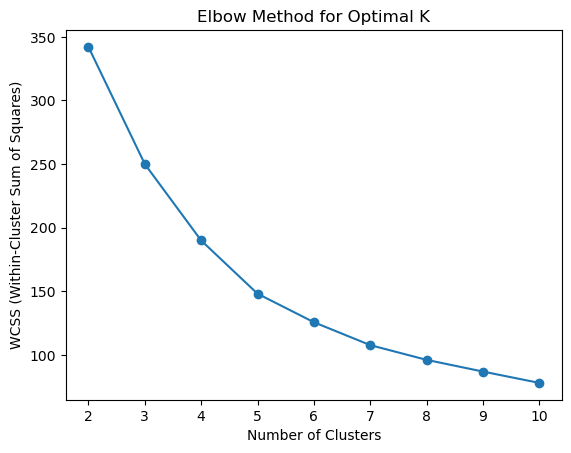

In [6]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

wcss = []
for k in range(2, 11):  
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(customer_features)
    wcss.append(kmeans.inertia_)

#plot elb-curve
plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Cluster Sum of Squares")
plt.title("Optimal K")
plt.show()



In [7]:
optimal_k = 4  # Adjust based on Elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_data["Cluster"] = kmeans.fit_predict(customer_features)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [8]:
db_index = davies_bouldin_score(customer_features, customer_data["Cluster"])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.9070459865008492


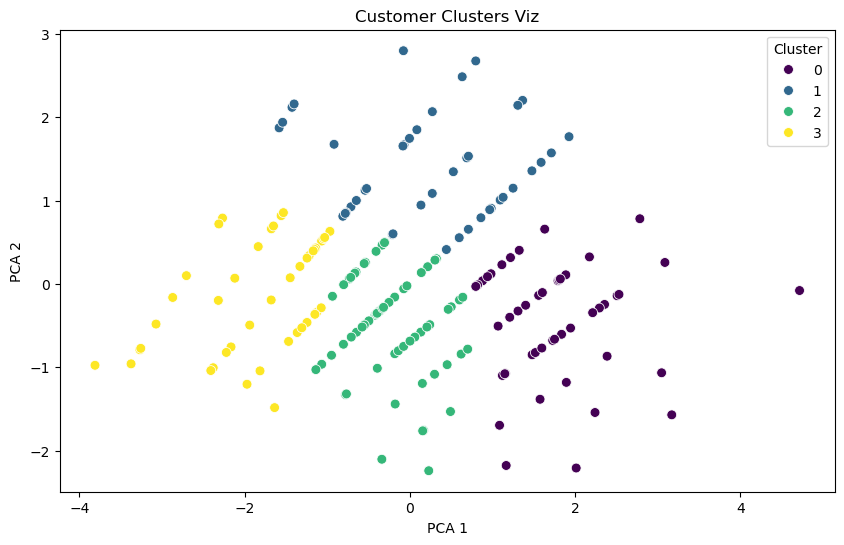

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(customer_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=customer_data["Cluster"], palette="viridis", s=50)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Customer Clusters Viz")
plt.legend(title="Cluster")
plt.show()


In [10]:
customer_data.to_csv("Customer_Segments.csv", index=False)


In [11]:
cluster_summary = customer_data.groupby("Cluster").agg(
    Count=('CustomerID', 'count'),
    AvgSpend=('TotalSpend', 'mean'),
    AvgTransactionCount=('TransactionCount', 'mean')
)
print(cluster_summary)


         Count     AvgSpend  AvgTransactionCount
Cluster                                         
0           48  5839.123333             7.708333
1           42  3569.492619             3.595238
2           67  3073.134925             5.447761
3           43  1253.463023             2.651163
